# Geotraces

In [4]:
import pandas as pd 
from time import time

In [5]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    print(c)
    # Radius of earth in kilometers is 6371
    km = 6371 * c
    return km

In [4]:
haversine(-3.8196207, 40.4381311, -3.6503509, 40.5327412)

0.0027884594332509925


17.765275049242074

In [6]:
from math import radians, degrees, sin, cos, asin, acos, sqrt
def great_circle(lon1, lat1, lon2, lat2):
    #print(lon1, lat1, lon2, lat2)
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    a=sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2)
    if a>1:
        a=1
    a=acos(a)
    return 6371 *a
    #return 6371 * (
    #    acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2))
    #)

In [6]:
great_circle(-3.8196207, 40.4381311, -3.6503509, 40.5327412)

17.765275049196333

In [9]:
def puntos_a_caminos(d):
    caminos=[]
    time_total=0
    dist_total=0
    speed=0
    for idx, row in d.iterrows():
        if idx>0:
            dist = great_circle(d.iloc[idx,5], d.iloc[idx,4], d.iloc[idx-1,5], d.iloc[idx-1,4])
            time = d.iloc[idx,0] - d.iloc[idx-1,0]
            if time>0:  # if time==0, speed=previous_speed
                speed = dist/time*3600  # conversion form seconds to hours
            time_total+=time
            dist_total+=dist
            accur = (d.iloc[idx, 6] + d.iloc[idx-1,6])/2
            offset = (d.iloc[idx, 7] + d.iloc[idx-1,7])/2
            caminos.append([dist, time, speed, accur, offset])
    d = pd.DataFrame(caminos, columns = ['Distance', 'Time (s)', 'Speed (km/h)', 'Accuracy', 'Offset']) 
    return d

# 1 user

In [74]:
start_time = time()
#-----------------------------------------------------------------
# read csv
df = pd.read_csv('./users_Madrid/39.csv', sep = '\t')
#-----------------------------------------------------------------
total_time = time() - start_time
print(str(total_time) + " segundos")

0.016637086868286133 segundos


In [75]:
df.head(21)

,Time Stamp,Date Time,Device ID,OS,Latitude,Longitude,Accuracy,Offset,Bus,Train,Airplane
0,1561935066,2019-07-01 00:51:06,39,0,40.556822,-3.637139,800,7200.0,False,False,False
1,1561935711,2019-07-01 01:01:51,39,0,40.553015,-3.637139,700,7200.0,False,False,False
2,1561936046,2019-07-01 01:07:26,39,0,40.554006,-3.635451,18,7200.0,False,False,False
3,1561940421,2019-07-01 02:20:21,39,0,40.556822,-3.637139,800,7200.0,False,False,False
4,1561941050,2019-07-01 02:30:50,39,0,40.556822,-3.637139,800,7200.0,False,False,False
5,1561942307,2019-07-01 02:51:47,39,0,40.552815,-3.643473,1100,7200.0,False,False,False
6,1561944426,2019-07-01 03:27:06,39,0,40.553879,-3.635518,15,7200.0,False,False,False
7,1561945361,2019-07-01 03:42:41,39,0,40.556822,-3.637139,800,7200.0,False,False,False
8,1561947182,2019-07-01 04:13:02,39,0,40.556822,-3.637139,800,7200.0,False,False,False
9,1561950805,2019-07-01 05:13:25,39,0,40.556812,-3.637455,800,7200.0,False,False,False


In [81]:
puntos_a_caminos(df)

,Distance,Time (s),Speed (km/h),Accuracy,Offset
0,0.423419,645,2.363270,750.0,7200.0
1,0.180218,335,1.936675,359.0,7200.0
2,0.344117,4375,0.283159,409.0,7200.0
3,0.000000,629,0.000000,800.0,7200.0
4,0.696377,1257,1.994398,950.0,7200.0
...,...,...,...,...,...
940,0.008904,21,1.526435,19.5,7200.0
941,0.117466,111,3.809707,18.5,7200.0
942,0.527862,132,14.396248,17.5,7200.0
943,10.863557,731,53.500416,43.5,7200.0


### Printing with folium

In [3]:
from datetime import datetime
import folium
from IPython.display import display

In [82]:
#Funcion para dibujar las velocidades en el camino con diferentes colores
def speed_color(speed):
    if speed < 0:
        raise ValueError
    elif speed >= 0 and speed < 5:
        return 'red'
    elif speed >= 10 and speed < 60:
        return 'yellow'
    else:
        return 'green'

In [83]:
userID = df['Device ID'][0]

#styles = ["Stamen Terrain", "Stamen Toner", "Mapbox Bright"]
points = df.head(47)
ways = puntos_a_caminos(df)
center = [40.4167278, -3.7033387] # Puerta del Sol (Madrid)
m = folium.Map(location=[center[0], center[1]], zoom_start=12)
    
for i in range(len(points)-1) : 
    dt_object = points.iloc[i, 1] 
    #Obtenemos dos ubicaciones para poder ir dibujando la linea que los une (poligono)
    p1 = [points.iloc[i, 4], points.iloc[i, 5]]
    p2 = [points.iloc[i+1, 4], points.iloc[i+1, 5]]
    speed = round(ways['Speed (km/h)'][i], 2) #Redondeamos los decimales de la velocidad
    folium.PolyLine(locations=[p1, p2], color=speed_color(speed), tooltip=str(speed) +' km/h').add_to(m)
    if i==0:
        folium.Marker(location=p1,popup= 'Punto de inicio: ' + str(dt_object), icon=folium.Icon(color='green')
                 ).add_to(m)
    elif i == len(points)-2:
        folium.Marker(location=p2,popup= 'Punto final: ' + str(dt_object), icon=folium.Icon(color='red')
                 ).add_to(m)
    else:
        folium.Circle(radius=20,location=p1,popup=dt_object,color='orange',
                 ).add_to(m)
        
display(m)

# N users

In [36]:
import glob

In [37]:
start_time = time()
#-----------------------------------------------------------------

path = './users_Baleares_tags' # use your path
all_files = glob.glob(path + "/*.csv")

for csv_user in all_files:
    df_aux = pd.read_csv(csv_user, sep = '\t')
    user = csv_user.split('/')[-1]
    
    speed = puntos_a_caminos(df_aux)['Speed (km/h)']
    df_aux['Speed (km/h)'] = 0
    for i, row in df_aux.iterrows():
        if i>0:
             df_aux.iloc[i,-1] = speed[i-1]
    df_aux.to_csv("./users_Baleares_tags_speed/"+user, sep='\t', index=False)
                
#-----------------------------------------------------------------
total_time = time() - start_time
print(str(total_time) + " segundos")

140.83241820335388 segundos


### Plot clustering 1 user

In [136]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
%matplotlib inline
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

In [58]:
start_time = time()
#-----------------------------------------------------------------
# read csv
df = pd.read_csv('./users_Madrid_speed/9684.csv', sep = '\t')
#-----------------------------------------------------------------
total_time = time() - start_time
print(str(total_time) + " segundos")

0.024377107620239258 segundos


In [68]:
len(df)

943

In [128]:
df_cluster = df[['Latitude','Longitude']]

[[40.40640564 -3.69525651]
 [40.42692946 -3.67388043]]


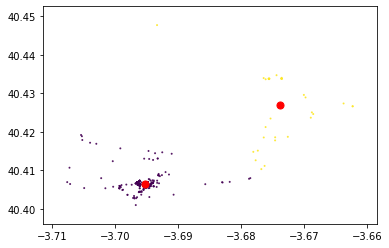

In [129]:
kmeans = KMeans(n_clusters=2).fit(df_cluster)
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(df_cluster['Longitude'], df_cluster['Latitude'],c=kmeans.labels_.astype(float), s=1, alpha=0.8)
plt.scatter(centroids[:, 1], centroids[:, 0], c='red', s=50)

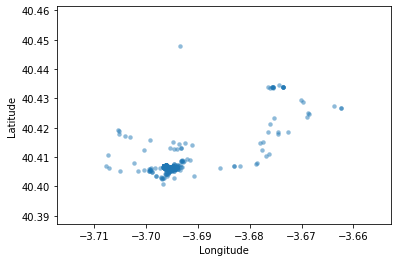

In [130]:
# scatterplot it to get a sense of what it looks like
df_cluster = df_cluster.sort_values(by=['Latitude', 'Longitude'])
ax = df_cluster.plot(kind='scatter', x='Longitude', y='Latitude', alpha=0.5, linewidth=0)

# Detección de estados de Markov

#### Trataremos de ver la correlación entre los resultados obtenidos con Overpass Turbo y las velocidades (km/h) que llevan los usuarios en cada posicion GPS registrada.

#### Usuarios relevantes:  51181 (Ultimo dia, ver autobus), 60430, 150247(bueno para el tren)

In [38]:
from time import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import math

In [68]:
states_id = ['En reposo', 'Andando', 'Bus', 'Tren', 'Coche']
def get_Markov_states(df):
    if len(df)<2:
        return []
    states = [[str(df.iloc[0, 1].hour) + ':' + str(df.iloc[0, 1].minute) , 'En reposo', 
               get_mins(df.iloc[1, 0] - df.iloc[0, 0])]]
    all_states = [[str(df.iloc[0, 1].hour) + ':' + str(df.iloc[0, 1].minute) , 'En reposo', 
               get_mins(df.iloc[1, 0] - df.iloc[0, 0])]]
    speeds = []
    sum_time = 0
    
    # Reseteamos los indices
    df = df.reset_index(drop=True)
    for i, row in df.iterrows():
        if i+1 == len(df): break
        speed = row['Speed (km/h)']
        time = str(df.iloc[i, 1].hour) + ':' + str(df.iloc[i, 1].minute)
        time_length = get_mins(df.iloc[i+1, 0] - df.iloc[i, 0])
        
        # STOPPED
        if speed < 2.78: 
            if all_states[-1][1] != 'En reposo':
                states.append([time, 'En reposo', time_length])
            else: 
                states[-1][2] += time_length
            all_states.append([time, 'En reposo', time_length])
        # WALK
        elif speed <= 8:
            if all_states[-1][1] != 'Andando':
                states.append([time, 'Andando', time_length])
            else: 
                states[-1][2] += time_length
            all_states.append([time, 'Andando', time_length])
        # TRAIN
        elif ((row['Train'] == True and speed > 8) 
            or (all_states[-1][1] == 'Tren' and speed > 8)):
            if all_states[-1][1] != 'Tren':
                states.append([time, 'Tren', time_length])
            else: 
                states[-1][2] += time_length
            all_states.append([time, 'Tren', time_length])
        # BUS
        elif ((row['Bus'] == True and speed > 8) 
            or (all_states[-1][1] == 'Bus' and speed > 8)):
            if all_states[-1][1] != 'Bus':
                states.append([time, 'Bus', time_length])
            else: 
                states[-1][2] += time_length
            all_states.append([time, 'Bus', time_length])
        # CAR
        elif speed > 15 or row['Fuel Station'] == True or (all_states[-1][1] == 'Coche' and speed > 15):
            if all_states[-1][1] != 'Coche':
                states.append([time, 'Coche', time_length])
            else: 
                states[-1][2] += time_length
            all_states.append([time, 'Coche', time_length])
    return states

def update_transition_matrix(matrix, transitions):
    if len(transitions)>1:
        for i in range(len(transitions)-1):
            matrix.loc[transitions[i][1], transitions[i+1][1]] += 1
            
def calculate_prob(matrix):
    for i in matrix.index:
        total = matrix.loc[i, :].sum()
        for j in matrix.columns:
            # Usamos estimador bayesiano
            if total != 0:
                matrix.loc[i, j] = (matrix.loc[i, j] + 1) / (total + len(states_id))
            else:
                matrix.loc[i, j] = 0
            
def get_mins(tstmp):
    mins = math.floor(tstmp/60)
    return mins

In [90]:
start_time = time()
#-----------------------------------------------------------------

print_figures = False

matrix_by_user = {}

# Matriz de transicion del usuario vacia
total_transition_matrix = pd.DataFrame(0, index=states_id, columns=states_id)

path = './users_Barcelona_tags_speed' # use your path
all_files = glob.glob(path + "/*.csv")

for csv_user in all_files:
    #if csv_user == './users_Madrid_tags_speed/106180.csv':
    df = pd.read_csv(csv_user, sep = '\t')
    user = csv_user.split('/')[-1]
    user = user.split('.')[0]
    print('User ID: '+str(user))

    # Matriz de transicion del usuario vacia
    transition_matrix = pd.DataFrame(0, index=states_id, columns=states_id)

    # Se crea una columna con la fecha legible
    df['Date Time'] = pd.to_datetime(df['Date Time'], format="%Y-%m-%d %H:%M:%S")

    for i in range(2, 30):
        #Ploteamos una grafica para cada dia del mes 7 (julio)
        df_plot = df[(df['Date Time']<datetime(2019, 7, i, 0, 0)) & (df['Date Time']>datetime(2019, 7, i-1, 0, 0))]

        if len(df_plot) < 5:
            continue

        # Obtenemos las transiciones del usuario
        states = get_Markov_states(df_plot)
        #print(states)

        # Actualizamos la matriz de transicion
        update_transition_matrix(transition_matrix, states)
        update_transition_matrix(total_transition_matrix, states)

        if print_figures == True:
            #Creamos el grafico
            x = df_plot['Date Time'].tolist()
            y = df_plot['Speed (km/h)'].tolist()
            plt.figure(figsize=(20,5))
            plt.step(x, y, where = 'mid', color = 'blue', linewidth = 2) 
            plt.xticks(rotation=20)
            plt.title(datetime(2019, 7, i-1).date())
            plt.xlabel('Hour')
            plt.ylabel('km/h')
            plt.ylim(0, 100)
            plt.grid()

            #BUS
            line_bus=0
            #Comprobamos para qué puntos hay True en tag=Bus
            df_bus = df_plot[df_plot['Bus']==True]
            if df_bus.empty == False:
                #Generamos linea ROJA discontinua para puntos que tienen tag_bus = True
                for index, item in enumerate(x):
                    if item in df_bus['Date Time'].tolist():
                        line_bus = plt.axvline(x[index], color='g', ls="dotted", linewidth = 3)
                line_bus.set_label('Bus stop')

            #TRAIN
            line_train=0
            #Comprobamos para qué puntos hay True en tag=Train
            df_train = df_plot[df_plot['Train']==True]
            if df_train.empty == False:
                #Generamos linea ROJA discontinua para puntos que tienen tag_bus = True
                for index, item in enumerate(x):
                    if item in df_train['Date Time'].tolist():
                        line_train = plt.axvline(x[index], color='m', ls="dotted", linewidth = 3)
                line_train.set_label('Train station')

            #Fuel Station
            #Comprobamos para qué puntos hay True en tag=Fuel Station
            df_fuelst = df_plot[df_plot['Fuel Station']==True]
            if df_fuelst.empty == False:
                #Generamos linea ROJA discontinua para puntos que tienen tag_bus = True
                for index, item in enumerate(x):
                    if item in df_fuelst['Date Time'].tolist():
                        line_fuel = plt.axvline(x[index], color='r', ls="dotted", linewidth = 3)
                line_fuel.set_label('Fuel Station')

            plt.legend(loc='best', borderaxespad=0)

            plt.show()

    calculate_prob(transition_matrix)
    matrix_by_user[user] = transition_matrix
    #print(transition_matrix)
    #print('\n')
    
calculate_prob(total_transition_matrix)
print('\nMatriz de transición del conjunto total de usuarios:')
print(total_transition_matrix)

#-----------------------------------------------------------------
total_time = time() - start_time
print(str(total_time) + " segundos")

User ID: 100049
User ID: 100208
User ID: 10084
User ID: 101010
User ID: 101802
User ID: 10202
User ID: 105175
User ID: 106561
User ID: 108559
User ID: 111693
User ID: 112529
User ID: 11323
User ID: 114881
User ID: 114925
User ID: 115647
User ID: 116189
User ID: 117419
User ID: 117761
User ID: 119686
User ID: 121027
User ID: 122135
User ID: 12248
User ID: 123016
User ID: 123278
User ID: 12458
User ID: 125447
User ID: 125700
User ID: 127150
User ID: 130520
User ID: 131167
User ID: 132305
User ID: 132910
User ID: 136633
User ID: 138676
User ID: 139953
User ID: 140231
User ID: 140312
User ID: 140448
User ID: 140694
User ID: 14292
User ID: 143218
User ID: 143466
User ID: 144147
User ID: 14480
User ID: 145572
User ID: 146907
User ID: 147080
User ID: 147529
User ID: 147551
User ID: 147726
User ID: 15273
User ID: 15594
User ID: 16784
User ID: 18302
User ID: 18903
User ID: 21224
User ID: 22815
User ID: 23049
User ID: 23389
User ID: 25418
User ID: 28265
User ID: 28771
User ID: 31671
User ID: 337

## Cálculo de la distribución estacionaria

### Método 1: Cálculo de la potencia n de la matriz de transición para conocer el estado estacionario

In [91]:
def get_stable_matrix(transition_matrix):
    # Pasamos la matriz a un array en numpy
    matriz = transition_matrix.to_numpy()
    n=500
    pn=np.linalg.matrix_power(matriz, n)
    return pn

In [92]:
# Obtenemos los vectores estacionarios de todos los usuarios
cluster_data = []
for m in matrix_by_user.values():
    bandera = True
    M = get_stable_matrix(m)
    for i in M:
        if round(i.sum()) != 1:
            bandera = False
            continue
    if bandera:
        cluster_data.append(M[0])
cluster_data

[array([0.2931752 , 0.28697131, 0.13947012, 0.1344243 , 0.14595908]),
 array([0.28619415, 0.34461913, 0.05778413, 0.22931595, 0.08208664]),
 array([0.37505408, 0.29682067, 0.07524813, 0.1025827 , 0.15029442]),
 array([0.45499268, 0.44953595, 0.03052385, 0.03809296, 0.02685456]),
 array([0.44542317, 0.40921797, 0.02142054, 0.07434769, 0.04959063]),
 array([0.358239  , 0.39653901, 0.0433207 , 0.15889961, 0.04300167]),
 array([0.31074937, 0.27088052, 0.05250339, 0.2270634 , 0.13880332]),
 array([0.22244727, 0.39558556, 0.06608802, 0.23261438, 0.08326477]),
 array([0.29440152, 0.34756969, 0.04659612, 0.22405375, 0.08737892]),
 array([0.44867615, 0.41988602, 0.05088915, 0.05089864, 0.02965004]),
 array([0.25417102, 0.33682807, 0.05828518, 0.2804543 , 0.07026142]),
 array([0.39141061, 0.32107668, 0.06893574, 0.12776198, 0.09081499]),
 array([0.32166444, 0.348142  , 0.03115427, 0.1814691 , 0.11757019]),
 array([0.41971451, 0.3622277 , 0.04815324, 0.09721862, 0.07268593]),
 array([0.4137774 , 

### Método 2: Resolución de la ecuación de distribución estacionaria

In [93]:
def get_stable_state(transition_matrix):
    # Resolviendo por matrices A = (AT-I) y el vector de ceros terminado en 1
    matriz = transition_matrix.to_numpy()
    k=len(matriz)
    A=matriz.transpose()
    A=A-np.identity(k, dtype=int)
    # la última fila se sustituye por la suma de probabilidades
    A[-1,:]=np.ones(k,dtype=int)
    B=np.zeros(k,dtype=int)
    B[-1]=1  # el último
    Pncalc=np.linalg.solve(A,B)
    #print('largo plazo')
    #print(Pncalc)
    return Pncalc

## Obtenemos los vectores estacionarios de cada usuario

In [94]:
# Obtenemos los vectores estacionarios de todos los usuarios
cluster_data = []
for m in matrix_by_user.values():
    bandera = True
    v = get_stable_state(m)
    for i in v:
        if i == 0:
            bandera = False
            continue
    if bandera:
        cluster_data.append(v.tolist())
cluster_data

[[0.2931752007515083,
  0.28697130718837877,
  0.1394701182948224,
  0.1344242976962164,
  0.1459590760690741],
 [0.4591648189209164,
  0.40746899893241356,
  0.026730721852673073,
  0.017984725301798475,
  0.08865073499219842],
 [0.2861941514853996,
  0.3446191328237368,
  0.057784129085327006,
  0.22931594973238528,
  0.08208663687315121],
 [0.37505407523397905,
  0.2968206682156611,
  0.07524813121418641,
  0.10258270256151558,
  0.15029442277465782],
 [0.4549926841989767,
  0.44953594965739124,
  0.030523853027608613,
  0.03809295592872906,
  0.026854557187294327],
 [0.4454231749272653,
  0.40921796868371424,
  0.021420536498717734,
  0.0743476868590384,
  0.04959063303126429],
 [0.35823900496622074,
  0.39653901294174176,
  0.043320695698859886,
  0.1588996115337705,
  0.043001674859407146],
 [0.31074937280153386,
  0.270880519337851,
  0.05250339091884307,
  0.22706339738757686,
  0.1388033195541952],
 [0.4022347031438043,
  0.3480243494621137,
  0.022126681024537485,
  0.0764924

## Clustering de vectores estacionarios

In [95]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [96]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km = km.fit(cluster_data)
    Sum_of_squared_distances.append(km.inertia_)

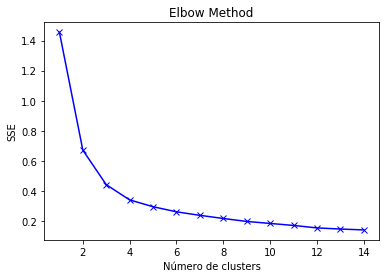

In [97]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

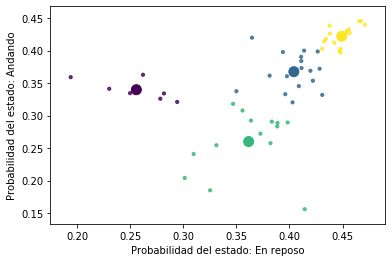

In [89]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(cluster_data)
centroids = kmeans.cluster_centers_
#print(centroids)
#print(kmeans.labels_)

state_X = 0
state_Y = 1

X = []
Y = []
for user in cluster_data:
    X.append(user[state_X])
    Y.append(user[state_Y])

plt.scatter(X, Y, s=10, alpha=0.8, c=kmeans.labels_.astype(float))
plt.scatter(centroids[:, state_X], centroids[:, state_Y], c =range(len(centroids)), s=100)
plt.xlabel('Probabilidad del estado: '+states_id[state_X])
plt.ylabel('Probabilidad del estado: '+states_id[state_Y])
plt.show()

In [67]:
list(zip(cluster_data, kmeans.labels_))
#[0 1 1 3 1 3 1 1 3 3 2 1 3 1 3 1 1 1 2 2 2 1 3 1 1 3 2 0 3 1 3 2 3 2 0 1 0
# 1 3 1 3 3 1 1]

[([0.31980463589327374,
   0.31280886954136383,
   0.14425800021374652,
   0.14094322518677121,
   0.08218526916484467],
  2),
 ([0.4508323128555766,
   0.4487221379034449,
   0.0274841889568529,
   0.022738585663636304,
   0.0502227746204893],
  3),
 ([0.29889703638904447,
   0.3533736049188421,
   0.06392834025966375,
   0.24707979863382737,
   0.03672121979862229],
  1),
 ([0.3996886217186352,
   0.3404944318320611,
   0.08660327260854872,
   0.10197947621724811,
   0.07123419762350691],
  0),
 ([0.45550379064626023,
   0.42348967179360664,
   0.02202275336603694,
   0.07691358844683133,
   0.022070195747264904],
  3),
 ([0.36072772898368893,
   0.39921765443944196,
   0.0436932614953133,
   0.15266809358624253,
   0.0436932614953133],
  0),
 ([0.3227087779955749,
   0.27481197947552033,
   0.04931754374657569,
   0.22513393149547511,
   0.12802776728685397],
  2),
 ([0.4108540549564944,
   0.3956749749572801,
   0.027670977942765105,
   0.07905888476420561,
   0.08674110737925472],

## Clustering sobre mapa 

In [243]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
%matplotlib inline
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

In [261]:
start_time = time()
#-----------------------------------------------------------------
# read csv
df_raw = pd.read_csv('./users_Madrid_tags_speed/17057.csv', sep = '\t')
# Se añade la columna Date Time para la fecha en formato legible
df['Date Time'] = pd.to_datetime(df['Date Time'], format="%Y-%m-%d %H:%M:%S")
#-----------------------------------------------------------------
total_time = time() - start_time
print(str(total_time) + " segundos")

0.01970195770263672 segundos


In [262]:
mapa = plt.imread('./map.png')

In [263]:
BBox = (-3.9087, -3.4555, 40.3311, 40.5313)

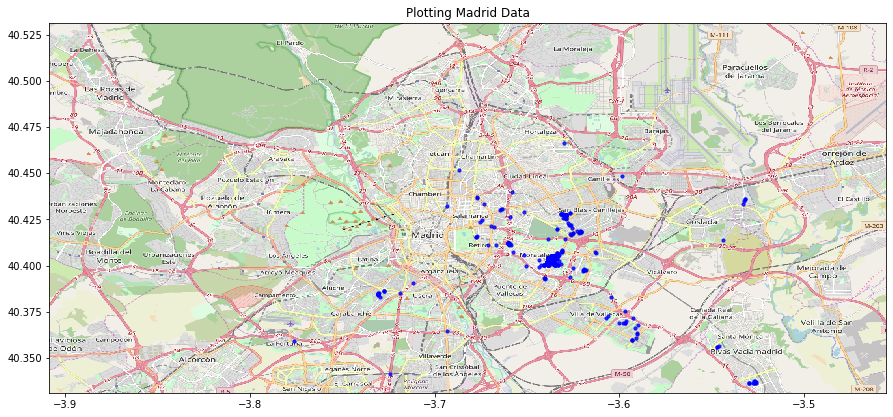

In [264]:
fig, ax = plt.subplots(figsize = (15,8))

ax.scatter(df_raw.Longitude, df_raw.Latitude, zorder=1, alpha= 0.8, c='b', s=10)
ax.set_title('Plotting Madrid Data')
ax.set_xlim(BBox[0], BBox[1])
ax.set_ylim(BBox[2], BBox[3])

ax.imshow(mapa, zorder=0, extent = BBox, aspect= 'equal')

[[40.40503853 -3.63686228]
 [40.36369079 -3.5577412 ]
 [40.38312419 -3.72687834]]


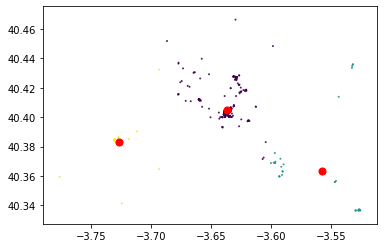

In [266]:
df_cluster = df_raw[['Latitude','Longitude']]
kmeans = KMeans(n_clusters=3).fit(df_cluster)
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(df_raw.Longitude, df_raw.Latitude, c=kmeans.labels_.astype(float), s=1, alpha=0.8)
plt.scatter(centroids[:, 1], centroids[:, 0], c='red', s=50)